## Photons in a Kerr spacetime

In this notebook we wish to integrate the null (or light-like) **geodesics** of a rotating (Kerr) **black-hole spacetime** in General Relativity. This means looking at the [**photons**](https://en.wikipedia.org/wiki/Photon) orbiting the rotating black hole.

Here we follow closely the method presented in [Pu et al. (2016)](https://ui.adsabs.harvard.edu/abs/2016ApJ...820..105P/abstract). The following code was developed during the tutorials of the Black Holes and Neutron Stars course (Dr. C. Fromm and Dr. R. Gold) at the ITP of the Goethe-Universität (Frankfurt am Main).

Using geometrized units, $c=G=1$, the [Kerr metric](http://www.roma1.infn.it/teongrav/leonardo/bh/bhcap3.pdf) in Boyer-Lindquist coordinates is written as
$$\mathrm{d}s^{2}=-\left(1-\frac{2Mr}{\Sigma}\right) \mathrm{d}t^{2}-\frac{4aMr\sin^{2}\theta}{\Sigma} \mathrm{d}t \mathrm{d}\phi+\frac{\Sigma}{\Delta} \mathrm{d}r^{2}+\Sigma \mathrm{d}\theta^{2}+\left(r^{2}+a^{2}+\frac{2a^{2}Mr\sin^{2}\theta}{\Sigma}\right) \sin^{2}\theta \mathrm{d}\phi^{2},$$
where $\Sigma\equiv r^2 + a^2 \cos^2 \theta$ and $\Delta\equiv r^2 - 2Mr + a^2$. For simplicity, we will set also $M=1$.

We start by importing all useful packages.

In [1]:
import numpy as np
import math

from scipy.integrate import odeint
from scipy.integrate import solve_ivp

from pylab import *
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Initial conditions

We create a function to evaluate **initial conditions** for each photon (this is an [initial value problem](https://en.wikipedia.org/wiki/Initial_value_problem#:~:text=An%20initial%20value%20problem%20is,solving%20an%20initial%20value%20problem)).

In order to do so, we must first set up a relation between an observer located at some distance $r_{\mathrm{obs}}$ and orientation $\theta_{\mathrm{obs}}$, $\phi_{\mathrm{obs}}$ from the black-hole frame. We designate the spatial coordinates for the observer frame by $\mathbf{\alpha}=\left(\alpha, \beta, \gamma\right)$ and we initialise them in a way that the $\gamma$-axis points in the $r_{\mathrm{obs}}$ direction; similarly, we adopt $\mathbf{x}=\left(x, y, z\right)$ for the black-hole frame.

Hence, the observer and black-hole frame are related by the transformation
$$\mathbf{x}=\left(\begin{array}{c}
\mathcal{D}(\beta, \gamma) \cos\phi_{\mathrm{obs}} -\alpha\sin\phi_{\mathrm{obs}} \\
\mathcal{D}(\beta, \gamma) \cos\phi_{\mathrm{obs}} + \alpha\cos\phi_{\mathrm{obs}} \\
\left(r_{\mathrm{obs}}-\gamma\right) \cos\theta_{\mathrm{obs}} + \beta\sin\theta_{\mathrm{obs}}
\end{array}\right),$$
with
$$\mathcal{D}\equiv\left(\sqrt{r_{\mathrm{obs}}^{2}+a^{2}}-\gamma\right) \sin\theta_{\mathrm{obs}}-\beta\cos\theta_{\mathrm{obs}}.$$

The conversion from cartesian to Boyer-Lindquist coordinates is given by
$$\begin{aligned}
r &=\sqrt{\frac{w + \sqrt{w^{2} + 4a^{2}z^{2}}}{2}} \\
\theta &=\arccos \left(\frac{z}{r}\right) \\
\phi &=\arctan\left(y, x \right)
\end{aligned},$$
where $w\equiv x^2 + y^2 + z^2 - a^2$.

We can now consider the velocity of the photon in Boyer-Lindquist coordinates, which can be written as
$$\begin{aligned}
\dot{r} &=-\frac{r \mathcal{R} \sin\theta\sin\theta_{\mathrm{obs}} \cos\Phi + \mathcal{R}^{2} \cos\theta \cos\theta_{\mathrm{obs}}}{\Sigma} \\
\dot{\theta} &=\frac{r \sin\theta \cos\theta_{\mathrm{obs}}-\mathcal{R} \cos\theta \sin\theta_{\mathrm{obs}} \cos\Phi}{\Sigma} \\
\dot{\phi} &=\frac{\sin\theta_{\mathrm{obs}} \sin\Phi}{\mathcal{R} \sin\theta}
\end{aligned},$$
where $\mathcal{R}\equiv \sqrt{r^2 + a^2}$ and $\Phi \equiv \phi - \phi_{\mathrm{obs}}$.

Now we are in a position to compute the initial values for $r,\, \theta,\, \phi,\, t,\, p_r$ and $p_\theta$, required to solve the geodesic equations.

In [2]:
def initial(alpha, beta, r0, theta0, phi0, a):
    
    # alpha  =  x-coordinate in the image plane 
    # beta   =  y-coordinate in the image plane
    # r0     =  distance to the observer
    # theta0 =  inclination of the observer
    # phi0   =  azimuthal angle of the observer
    # a      =  spin of the black hole
    
    #####
    #calculate initial position
    #####
    
    # correct for small angles in order to avoid zeros
    if abs(theta0)<1e-8:
        theta0=sign(theta0)*1e-8
    if abs(phi0)<1e-8:
        phi0=sign(phi0)*1e-8
        
    # some shorthands
    a2 = a**2
    r2 = r0**2
    
    # transformation from observer (with gamma=0) to BH frame
    D = sqrt(r2+a2)*sin(theta0) - beta*cos(theta0)
    
    x= D*cos(phi0) - alpha*sin(phi0)
    y= D*sin(phi0) + alpha*cos(phi0)
    z= r0*cos(theta0) + beta*sin(theta0)
    
    w = x**2 + y**2 + z**2 - a2
    
    # initial 6D-vector (r, theta, phi, t, p_r, p_theta)
    y0 = np.zeros(6)
    
    # convert cartesian to Boyer-Lindquist coords
    y0[0] = sqrt((w+sqrt(w*w+(2.*a*z)*(2.*a*z)))/2.)
    y0[1] = np.arccos(z/y0[0])
    y0[2] = np.arctan2(y, x)
    y0[3] = 0
    
    ########
    #calculate initial velocities
    ########
    
    # to make programming easier
    r=y0[0]
    theta=y0[1]
    phi=y0[2]
    
    # auxiliary variables
    sigma = r**2 + (a*cos(theta))**2
    R = sqrt(a2 + r**2)
    v = -sin(theta0)*cos(phi) # reflect velocity: inverse ray-tracing
    zdot = -1.
    
    # initial velocities in Boyer-Lindquist coords
    rdot0 = zdot*(-R*R*cos(theta0)*cos(theta)+r*R*v*sin(theta))/sigma
    thetadot0 = zdot*(cos(theta0)*r*sin(theta)+R*v*cos(theta))/sigma
    phidot0 = zdot*sin(theta0)*sin(phi)/(R*sin(theta))
    
    # additional variables
    r2 = r**2
    delta = r2 - 2.0*r + a2
    s1 = sigma -2.0*r
    
    # conserved energy (see later on)
    E = sqrt( s1*(rdot0**2/delta + thetadot0**2) + delta*(sin(theta)**2)*phidot0**2 )
    
    # conserved 4-momentum (rescaled by energy; see later on)
    y0[4]= (rdot0*sigma/delta)/E
    y0[5] = (thetadot0*sigma)/E
    
    # compute angular momentum (see later on)
    L = ((sigma*delta*phidot0 - 2.0*a*r*E)*(sin(theta)**2)/s1)/E
    
    # compute kappa (see later on)
    kappa = y0[5]**2 + a2*(sin(theta)**2) + L**2/(sin(theta)**2)
    
    # return initial-condition vector, energy, angular momentum and kappa as a dictonary
    return {'y0': y0, 'E': E, 'L': L, 'kappa': kappa}

## Geodesic equations

Now we evaluate the [geodesic equations](https://en.wikipedia.org/wiki/Geodesics_in_general_relativity) for a massless particle in a Kerr spacetime, namely given by
$$\begin{aligned}
\dot{r} &=\frac{\Delta}{\Sigma} p_{r} \\
\dot{\theta} &=\frac{1}{\Sigma} p_{\theta} \\
\dot{\phi} &=\frac{2arE+(\Sigma-2r) L_{z} \csc^{2}\theta}{\Sigma \Delta} \\
\dot{t} &=E+ \frac{2r\left(r^2 + a^2\right) E-2arL_{z}}{\Sigma \Delta} \\
\dot{p}_{r} &=\frac{1}{\Sigma \Delta}\left[-\kappa(r-1) + 2r\left(r^2+a^2\right) E^2 - 2aEL_{z}\right]-\frac{2p_{r}^{2}(r-1)}{\Sigma} \\
\dot{p}_{\theta} &=\frac{\sin\theta \cos\theta}{\Sigma}\left[\frac{L_{z}^{2}}{\sin^4 \theta}-a^2 E^2\right]
\end{aligned},
$$
where $E$ and $L_z$ are the conserved energy and angular momentum of the massless particle, which can be computed from the initial conditions using
$$\begin{aligned}
E^{2} &=\frac{\Sigma-2r}{\Sigma\Delta}\left(\Sigma \dot{r}^2+\Sigma\Delta\dot{\theta}^2\right)+\Delta\dot{\phi}^2\sin ^2 \theta \\
L_{z} &=\frac{(\Sigma\Delta\dot{\phi} - 2arE) \sin^2 \theta}{\Sigma - 2r}
\end{aligned}.$$
The last missing term in the above equations is
$$\kappa\equiv p^2_\theta +L^2_z \csc^2 \theta + a^2 -E^2 \sin^2 \theta.$$

In [3]:
def ODEray(t, y, a, kappa, E, L):
    
    # t      =  t or affine parameter 
    # y      =  6D state vector (r,theta,phi,t,p_r,p_theta)
    # a      =  black hole spin
    # kappa  =  kappa
    # E      =  conserved energy for each ray
    # L      =  conserved angular momentum for each ray
    
    # get variables to make programming clearer to read
    r = y[0]
    theta = y[1]
    phi = y[2]
    t = y[3]
    p_r = y[4]
    p_th = y[5]
    
    # auxiliary variables
    r2, a2 = r**2, a**2
    sin_th, cos_th = sin(theta), cos(theta)
    sigma = r2 + a2*(cos(theta)**2)
    delta = r2 - 2.0*r + a2
    
    # avoid small numbers
    if abs(sin_th)<1e-8:
        sin_th = sign(sin_th)*1e-8
        
    # set equation array for derivatives
    eqs = np.zeros(6)
    
    # geodesic equations
    eqs[0] = -p_r*delta/sigma
    eqs[1] = -p_th/sigma
    eqs[2] = -(2.0*r*a + (sigma-2.0*r)*L/(sin_th**2))/(sigma*delta)
    eqs[3] = -(1.0 + (2.0*r*(r2+a2) - 2.0*r*a*L)/(sigma*delta))
    eqs[4] = -(((r-1.0)*(-kappa) + 2.0*r*(r2+a2) - 2.0*a* L)/(sigma*delta) - 2.0*(p_r**2)*(r - 1.0)/sigma)
    eqs[5] = - sin_th*cos_th*(L**2 / sin_th**4 - a2)/sigma
    
    return eqs

## Integrating the geodesics

Now we can solve the geodesic equations. But, before doing so, we should tell the integrator when it should stop.

In [4]:
def hit_r_EH(t, y):
    
    # stop rays at the horizon
    r_EH = M + sqrt(M**2 - a**2)
    
    return y[0] - abs(r_EH + 1e-2)

def leavimg(t, y):
    
    # stop rays after some distance
    return 15 - abs(y[0])

Then, we combine all the (sub-)routines in one, and compute a ray solving the initial value problem with the ```solve_ivp``` function.

In [5]:
def ray(M, a, r0, alpha, beta, theta0, phi0, tmin, tmax):
    
    init_cond = initial(alpha, beta, r0, theta0, phi0, a)
    kappa, E, L = init_cond['kappa'], init_cond['E'], init_cond['L']
    
    # set terminate conditions for the scipy integrator
    # stop rays which hit the horizon
    hit_r_EH.terminal = True
    
    # stop rays which travelled to r greater than a certain value to be chosen
    leavimg.terminal = True
    
    # call ODE solver
    # see https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html#scipy.integrate.solve_ivp
    solver = solve_ivp(lambda t, y: ODEray(t, y, a, kappa, E, L),
                       t_span=[tmin, tmax], y0 = init_cond['y0'],
                       method = 'Radau', events=(hit_r_EH,leavimg),
                       dense_output = True,
                       atol = 1e-8, rtol = 1e-6)
    
    # compute x, y, z in cartesian coords
    x = solver.y[0,:]*cos(solver.y[2,:])*sin(solver.y[1,:])
    y=solver.y[0,:]*sin(solver.y[2,:])*sin(solver.y[1,:])
    z=solver.y[0,:]*cos(solver.y[1,:])
    
    return {'solver': solver, 'x': x, 'y': y, 'z': z}

## Plotting

Finally, we build a function to plot the photon together with the relevant black-hole surfaces. These are the *Event Horizon* and the *static-limit surface* (outer boundary of the *ergosphere*), defined by
$$\begin{aligned}
r_{\mathrm{EH}} &\equiv M + \sqrt{M^2 - a^2}, \\
r_{\mathrm{SL}} &\equiv M + \sqrt{M^2 - a^2\cos^2\theta}.
\end{aligned}$$

In [6]:
def plot3d_ray(x, y, z, dim, M, a):
    
    fig = plt.figure()
    ax = fig.gca(projection='3d', facecolor='w')
    
    for i in range(len(x)):
        plot(x[i], y[i], z[i], ls='-', lw=0.5)
    
    ax.set_xlabel('$x$')
    ax.set_xlim3d(dim[0], dim[1])
    ax.set_ylabel('$y$')
    ax.set_ylim3d(dim[2], dim[3])
    ax.set_zlabel('$z$')
    ax.set_zlim3d(dim[4], dim[5])
    locator_params(nbins=4)
    
    u, v = np.linspace(0, 2*np.pi, 100), np.linspace(0, np.pi, 100)
    
    xx=np.outer(np.cos(u), np.sin(v))
    yy=np.outer(np.sin(u), np.sin(v))
    zz=np.outer(np.ones(np.size(u)), np.cos(v))
    
    r_EH = M + sqrt(M**2 - a**2)
    r_SL = M + sqrt(M**2 - a**2*cos(v)**2)
    
    x_EH = r_EH * xx
    y_EH = r_EH * yy
    z_EH = r_EH * zz
    
    x_SL = r_SL * xx
    y_SL = r_SL * yy
    z_SL = r_SL * zz
    
    ax.plot_surface(x_EH, y_EH, z_EH, color='k', alpha=1)
    ax.plot_surface(x_SL, y_SL, z_SL, color='b', alpha=0.2)
    
    fig.savefig('wow.png', dpi=200)
    show()

Now we can set black-hole parameters (there are just 2!), the observer position and the initial position of the photon.

In [7]:
M = 1
a = 0.9

# observer position
theta0 = 90*np.pi/180
phi0 = 0*np.pi/180
r0 = 10

# initial position of the ray in the image plane (obs. frame)
alpha = 6.475479
beta = 0

# start and stop time for array integration
t_start = 0
t_stop = 90

Let's try everything out, specifying also the dimensions of the box used for plotting.

In [8]:
photon = ray(M, a, r0, alpha, beta, theta0, phi0, t_start, t_stop)
dim = [-10, 10, -10, 10, -10, 10]

Now we can launch our photon!

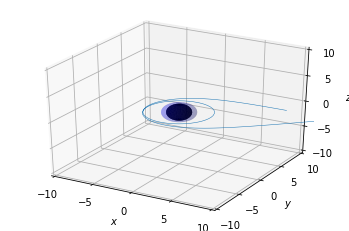

In [9]:
plot3d_ray([photon['x']], [photon['y']], [photon['z']],
                         dim, M, a)

But we can also plot a bunch photons, shot from slightly different positions from the observer plane.

In [10]:
def plot3d_multiray(M, a, alphas, betas, r0, theta0, phi0, tmin, tmax, dim):
    
    x_plot=[]
    y_plot=[]
    z_plot=[]
    
    for alpha in alphas:
        for beta in betas:
            photon = ray(M, a, r0, alpha, beta, theta0, phi0, tmin, tmax)
            x_plot.append(photon['x'])
            y_plot.append(photon['y'])
            z_plot.append(photon['z'])
            
    plot3d_ray(x_plot, y_plot, z_plot, dim, M, a)

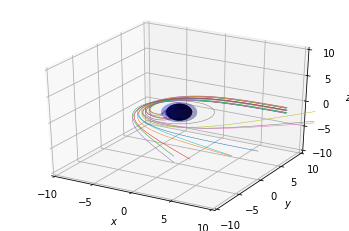

In [11]:
M = 1
a = 0.9

alpha = [6.32, 6.40, 6.475479, 6.55, 6.62]
beta = [-0.5, 0, 0.5]

r0 = 10
theta0 = 90*np.pi/180
phi0 = 0*np.pi/180

t_start = 0
t_stop = 90

dim = [-10, 10, -10, 10, -10, 10]

plot3d_multiray(M, a, alpha, beta, r0, theta0, phi0, t_start, t_stop, dim)

## Light deflection

We now wish to investigate further the behaviour of photons for different impact parameters $b$ (distance between the geodesic and the black hole in the image plane). Here we follow a study by [Gralla et al. (2019)](https://arxiv.org/pdf/1906.00873.pdf).

First of all, in analogy to ```ray```, we define a function which enables us to directly compute several photon geodesics together.

In [12]:
def multiray(M, a, r0, theta0, phi0, alphas, betas, tmin, tmax):
    
    # alphas = list of x-positions on the image plane
    # betas  = list of y-positions on the image plane
    
    result = []
    
    for alpha in alphas:
        for beta in betas:
            geodesic = ray(M, a, r0, alpha, beta, theta0, phi0, tmin, tmax)
            result.append(geodesic)
            
    return result

We carry out our analysis in the equatorial plane, $\theta=\pi/2$, and colour photon geodesics according to their *winding parameter* $n\equiv \phi/2\pi$ around the black hole. The adopted colour scheme and terminology are the following:

$$\begin{aligned}
n & <\frac{3}{4} & \mathrm{\color{black}{direct}} \\
\frac{3}{4}\leq n & <\frac{5}{4} & \mathrm{\color{gold}{lensed}} \\
n & \geq \frac{5}{4} &\mathrm{\color{red}{photon\, ring}}
\end{aligned}$$

In [13]:
def ray_analysis(rays, M, a, dim=[-10, 10, -10, 10, -10, 10]):
    
    # rays = list of rays
    # dim  = plot range
    
    fig = plt.figure(figsize=(12,9))
    ax = fig.gca(aspect='equal', facecolor='w')
    
    for i in (rays):
        
        # recall that each element in rays has the following order:
        # [solver output, x, y, z]
        
        # access the object i to get the last (-1) phi-value (2)
        phi = abs(i['solver'].y[2, -1])
        
        n = phi/(2.*np.pi)
        
        if n<3./4:
            mycolor = 'black'
        elif 3./4 <= n <5./4:
            mycolor = 'gold'
        else:
            mycolor = 'red'
            
        plot(i['x'], i['y'], marker='None', color=mycolor, ls='-', lw=1)
        
    ax.set_xlabel('$x [M]$')
    ax.set_xlim(dim[0], dim[1])
    ax.set_ylabel('$y [M]$')
    ax.set_ylim(dim[2], dim[3])
    
    sec_ax = ax.secondary_yaxis('right')
    sec_ax.set_ylabel('$b [M]$')
    sec_ax.set_yticks(list(range(0, 11)))
    
    r_EH = M + sqrt(M**2 - a**2)
    shadow = plt.Circle((0,0), r_EH, color='k')
    ax.add_artist(shadow)
    
    fig.savefig(f'a={a}.png', dpi=200)
    show()

We consider first a Schwarzschild black hole ($a=0$) and photons with an impact parameter $b$ ranging from $0M$ to $10M$. Clearly with our set-up $b$ is given by definition by the image-plane coordinate $\alpha$.

In [14]:
M = 1
a = 0

alpha1 = np.linspace(0, 10, 100)
alpha2 = np.linspace(5, 5.4, 150)
alpha = np.concatenate((alpha1,alpha2))
beta = [0]

r0 = 10
theta0 = 90*np.pi/180
phi0 = 0*np.pi/180

t_start = 0
t_stop = 90

rays_S = multiray(M, a, r0, theta0, phi0, alpha, beta, t_start, t_stop)

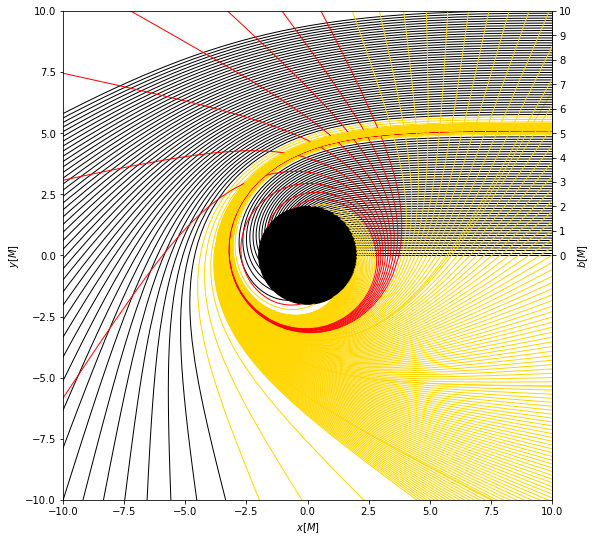

In [15]:
ray_analysis(rays_S, M, a)

Then we move on to consider a quasi-extremal rotating black hole for similar impact parameters.

In [16]:
M = 1
a = 0.99

alpha1 = np.linspace(0, 10, 100)
alpha2 = np.linspace(6.1, 6.9, 80)
alpha = np.concatenate((alpha1,alpha2))
beta = [0]

r0 = 10
theta0 = 90*np.pi/180
phi0 = 0*np.pi/180

t_start = 0
t_stop = 90

rays_K = multiray(M, a, r0, theta0, phi0, alpha, beta, t_start, t_stop)

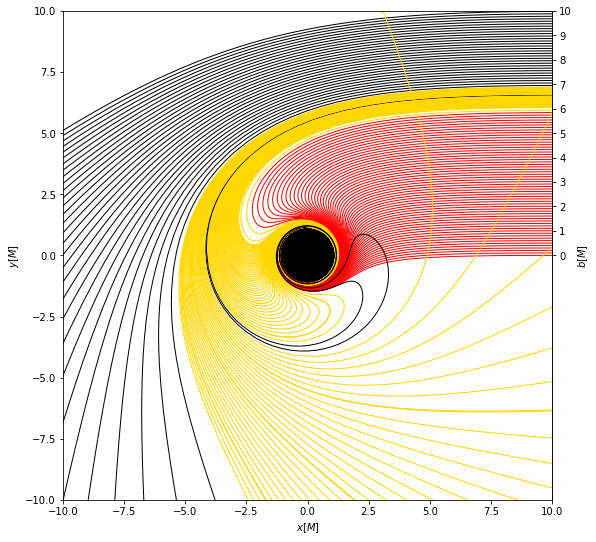

In [17]:
ray_analysis(rays_K, M, a)